In [1]:
# import statements
import csv
import pandas as pd
import numpy as np

# import packages for plotting
from matplotlib import pyplot as plt
import seaborn as sns

# import packages for encoding
from sklearn.preprocessing import StandardScaler

# import packages for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import packages for model building
from sklearn.ensemble import RandomForestClassifier

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
train = pd.read_csv('Data/train_values.csv')
labels = pd.read_csv('Data/train_labels.csv')
test = pd.read_csv('Data/test_values.csv')

## Step 1 - Data Preprocessing

The total training data set has 260,001 entries and no duplicates.

In [3]:
train_lbl = pd.merge(train, labels, on='building_id', how='inner')

In [4]:
train_lbl

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,0,2


Next up, we will check if there are any missing values.

In [5]:
train_lbl.isna().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

There are no missing values! 

### Baseline model score

Our baseline model will be a random forest classifier.

In [6]:
def baseline_score(dataframe):
    dummy_train = pd.get_dummies(dataframe)
    
    X_train = dummy_train
    X_train.drop(columns = ['damage_grade', 'building_id'], inplace = True)
    y_train = dataframe.iloc[:, -1]
    
    X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)
    
    baseline_model = RandomForestClassifier(n_jobs=-1,random_state=1)
    baseline_model.fit(X_train1, y_train1)
    y_pred = baseline_model.predict(X_val)
    score = f1_score(y_val, y_pred, average='micro')
    
    return baseline_model, y_val, y_pred, score

In [7]:
baseline_model, y_val, y_pred, score = baseline_score(train_lbl)

print(score)

0.7102492933065578


Our baseline score is about 0.710

## Step 2 - Data Cleaning & Analysis

### 1. Classify all features

A a next step, we will differentiate between three types of data categories:
1. numerical features (analyse skewness)
2. binary features (analyse sparsity)
3. categorical features (analyse cardinality and decide on encoding method)

In [8]:
num_fts = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

binary_fts = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
              'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
              'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
              'has_superstructure_timber', 'has_superstructure_bamboo',
              'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
              'has_superstructure_other',
              'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel',
              'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school',
              'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office',
              'has_secondary_use_use_police', 'has_secondary_use_other']

geo_fts = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

cat_fts = ['land_surface_condition', 'foundation_type', 'roof_type',
           'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration',
           'legal_ownership_status']

fts_dict = {'num_fts': num_fts, 'binary_fts': binary_fts, 'geo_fts': geo_fts, 'cat_fts': cat_fts}

We chose to view the geographical data (geo_level_1_id, geo_level_2_id, geo_level_3_id) as categorical data even though it is currently formatted in integers. Reasoning: the geographical data denotes the "geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). However, level 1 goes from 0 to 30 and maybe (we don't know) subregion 1 is actually next to subregion 22. As the earthquake obviously hit some regions harder than it did others, maybe subregions 1 and 22 were then very hard hit, but not the ones in between. So there is no ordinality. The following analysis shows that there is not much sense behind these values in terms of their ordinality.

<AxesSubplot:ylabel='geo_level_1_id'>

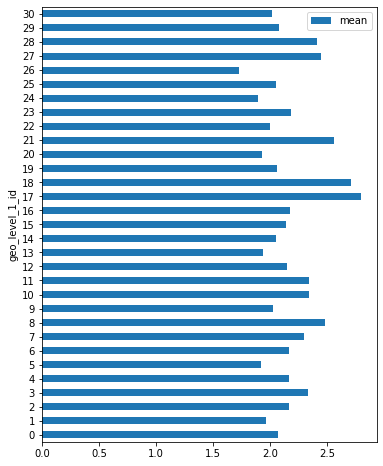

In [9]:
# plot mean of geo_level_1_id

gl1_df = train_lbl.groupby('damage_grade')['geo_level_1_id'].value_counts().unstack().transpose()
gl1_df['count'] = gl1_df.sum(axis=1)
gl1_df[2] = gl1_df[2] * 2
gl1_df[3] = gl1_df[3] * 3

gl1_df['mean'] = gl1_df.loc[:, [1, 2, 3]].sum(axis=1) / gl1_df['count']

gl1_df.plot(y = 'mean', kind = 'barh', figsize = [6, 8])

#### Numerical features

Firstly, we will have a look at their skewness and take action, if necessary. If our data is skewed, this may negatively impact the performance of our models as this tells us that the corresponding distributions are not symmetric.

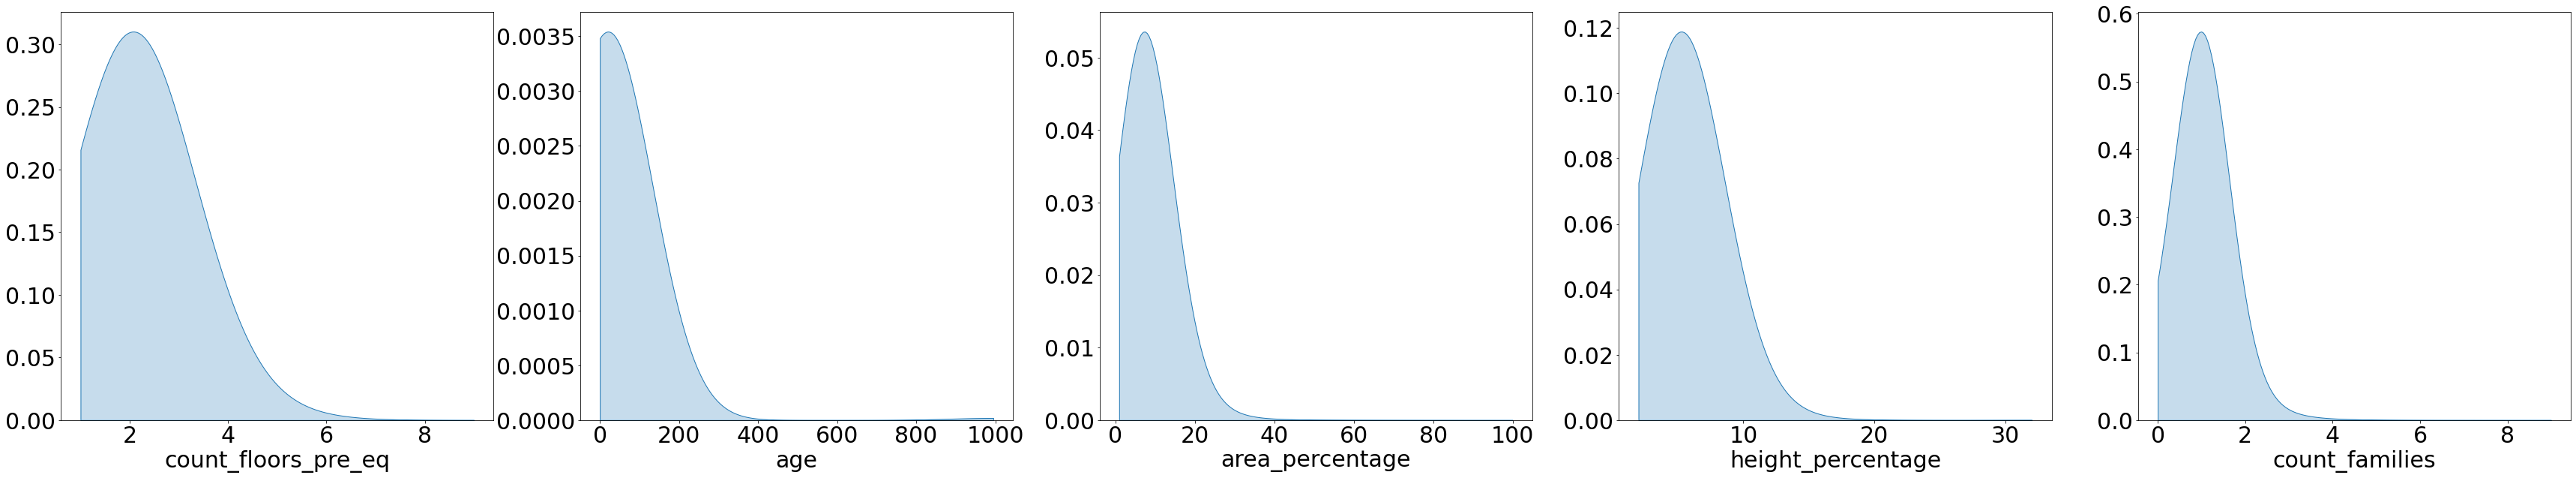

In [10]:
num_fts = fts_dict['num_fts']
num_fts_df = train_lbl.loc[:, num_fts]

fig, axs = plt.subplots(1, 5, figsize = (60, 10))
for i, ax in enumerate(axs.flat):
    sns.kdeplot(num_fts_df.iloc[:, i], bw_method = 1.5, ax = ax, cut = 0, shade = True)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    ax.set_xlabel(num_fts[i], fontsize = 30)
    ax.set(ylabel = None)

From the plots above, we can see that our data is extremely skewed and needs proper handling. We will do this by applying the natural logarithm to these variables. Before doing so, we must handle the 0 value (ln 0 not defined). As, very conveniently in this case, all distributions start at 0, we can simply add 1 to all numerical features before taking the natural logarithm.

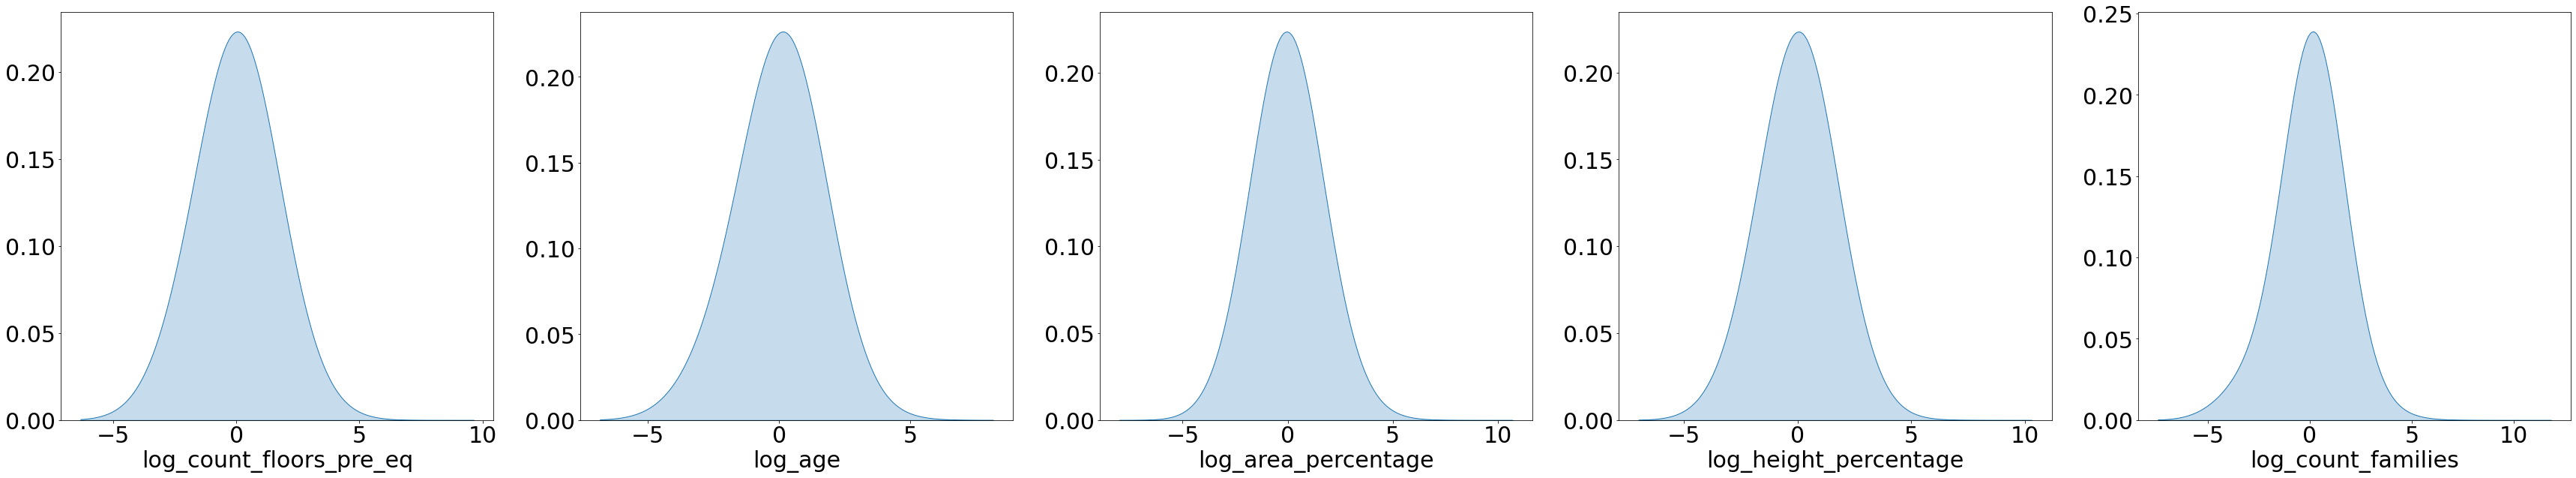

In [11]:
log_names = ['log_{}'.format(x) for x in num_fts]
fts_dict['log_num_fts'] = log_names

log_train_lbl = train_lbl.loc[:, num_fts].apply(lambda x: np.log(x + 1))
log_train_lbl.columns = log_names
scaler = StandardScaler().fit(log_train_lbl)
stand_log_train = scaler.transform(log_train_lbl) # standardize log-features (remove mean, scale to unit variance)
stand_log_train_df = pd.DataFrame(stand_log_train, columns = log_names)

# apply same transformations to test data
log_test = test.loc[:, num_fts].apply(lambda x: np.log(x + 1))
log_test.columns = log_names
stand_log_test = scaler.transform(log_test)
stand_log_test_df = pd.DataFrame(stand_log_test, columns = log_names)

fig, axs = plt.subplots(1, 5, figsize = (60, 10))
for i, ax in enumerate(axs.flat):
    sns.kdeplot(stand_log_train_df.iloc[:, i], bw_method = 1.5, ax = ax, shade = True)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    ax.set_xlabel('log_' + num_fts[i], fontsize = 30)
    ax.set(ylabel = None)

In [12]:
for log_col in stand_log_train_df:
    train_lbl.loc[:, log_col] = stand_log_train_df.loc[:, log_col]

for log_col in stand_log_test_df:
    test.loc[:, log_col] = stand_log_test_df.loc[:, log_col]

Other normalization approach: boxcox transformation instead of logarithm + StandardScaler

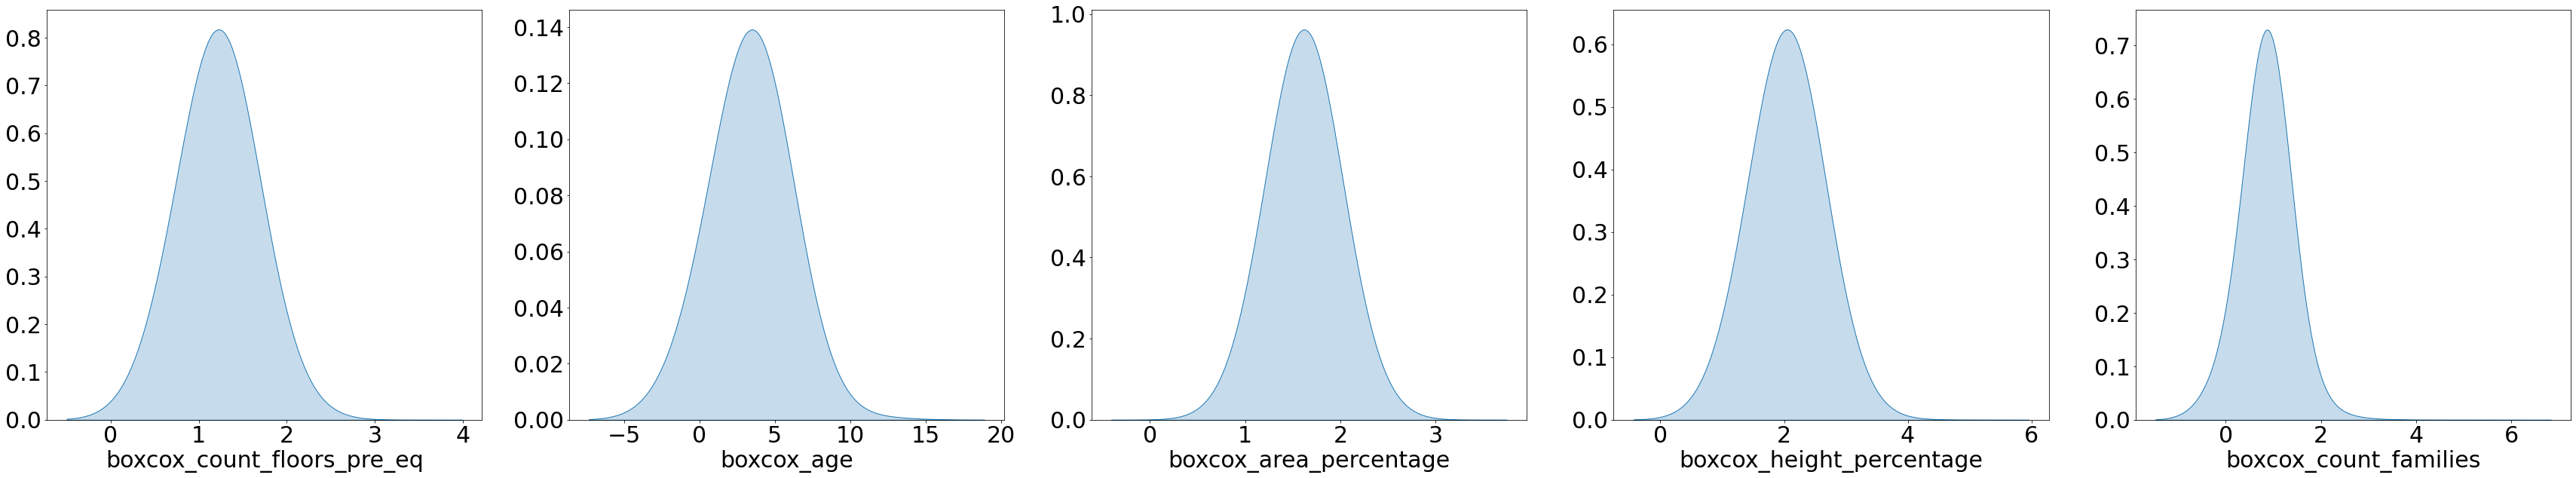

In [13]:
from scipy import stats

boxcox_names = ['boxcox_{}'.format(x) for x in num_fts]
fts_dict['boxcox_num_fts'] = boxcox_names

boxcox_train_lbl = pd.DataFrame()
boxcox_test = pd.DataFrame()

for i, ft in enumerate(boxcox_names):
    boxcox_train_lbl[ft], lmbda = stats.boxcox(train_lbl[num_fts[i]].apply(lambda x: x + 1))
    boxcox_test[ft] = stats.boxcox(test[num_fts[i]].apply(lambda x: x + 1), lmbda = lmbda) # do same transformation to test data with found lmbda

fig, axs = plt.subplots(1, 5, figsize = (60, 10))
for i, ax in enumerate(axs.flat):
    sns.kdeplot(boxcox_train_lbl.iloc[:, i], bw_method = 1.5, ax = ax, shade = True)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
    ax.set_xlabel('boxcox_' + num_fts[i], fontsize = 30)
    ax.set(ylabel = None)

In [14]:
for boxcox_col in boxcox_train_lbl:
    train_lbl.loc[:, boxcox_col] = boxcox_train_lbl.loc[:, boxcox_col]
train_lbl.drop(columns = num_fts, inplace = True)

for boxcox_col in boxcox_test:
    test.loc[:, boxcox_col] = boxcox_test.loc[:, boxcox_col]
test.drop(columns = num_fts, inplace = True)

In [15]:
column_to_reorder = train_lbl.pop('damage_grade')
train_lbl.insert(len(train_lbl.columns), 'damage_grade', column_to_reorder)

In [16]:
log_cols = ['building_id'] + fts_dict['log_num_fts'] + fts_dict['binary_fts'] + fts_dict['cat_fts'] + fts_dict['geo_fts'] + ['damage_grade']
boxcox_cols = ['building_id'] + fts_dict['boxcox_num_fts'] + fts_dict['binary_fts'] + fts_dict['cat_fts'] + fts_dict['geo_fts'] + ['damage_grade']

log_train_lbl = train_lbl[log_cols]
boxcox_train_lbl = train_lbl[boxcox_cols]

baseline_model, y_val, y_pred, score = baseline_score(log_train_lbl)
print('log_num_fts score:', score)

baseline_model, y_val, y_pred, score = baseline_score(boxcox_train_lbl)
print('boxcox_num_fts score:', score)

log_num_fts score: 0.7120783822156278
boxcox_num_fts score: 0.7110423248615393


#### Binary features

To understand the possible added value from the binary features, we will look at their sparsity (simply calculate the mean of the column and see what the average value is --> if it is very close to 0, then the column is sparse and is very likely to provide only few insights).

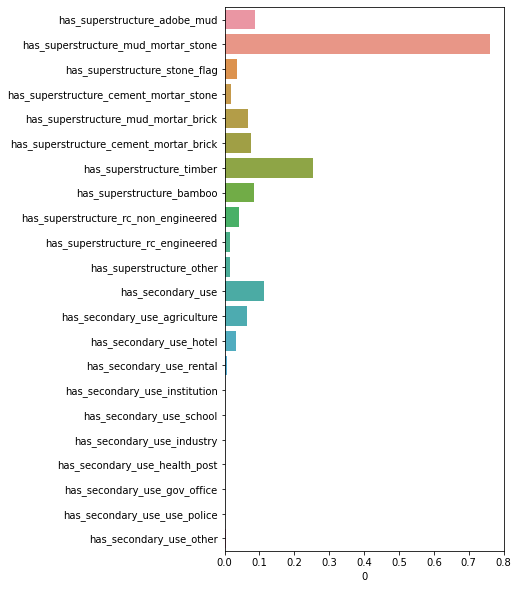

In [17]:
binary_fts = fts_dict['binary_fts']

mean_binary_fts_df = pd.DataFrame(train_lbl.loc[:, binary_fts].mean())
mean_binary_fts_df.loc[:, 'type'] = mean_binary_fts_df.index

fig, ax = plt.subplots(1, 1, figsize = (5, 10))
ax = sns.barplot(x = 0, y = 'type', data = mean_binary_fts_df, orient = 'h')
ax.set(ylabel = None)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10);

Most binary features are very sparse and not likely to provide insights for our models.

#### Categorical features

Regarding the categorical features, we will start with the geographical data. Intuitively, the geographical data should be the most important set of features as nothing should impact the destruction level of a house as much as the location where it was located (if the earthquake is in Nepal and you are in Paris, you should not really notice anything).

As the geographical data has no ordinality (see analysis under Step 2.1), we have to find a meaningful way to encode the provided three geographical levels. Our best idea so far was to apply *Target Encoding* as we deal with three columns of increasing cardinality (first level has 31 unique values, second level 1428 and third level 12568). To get a better grasp of how much the earthquake impacted this region, we will consequently calculate the mean and standard deviation for each of the regions. 

However, due to the increasing cardinality of the features, we might run into problems. Maybe a specific level 3 id has only one entry. Calculating this entries mean and standard deviation might not be representative of the population in this subregion and could introduce high bias and high variance. 

While searching online, we found a potential method to deal with this problem: *Empirical Bayes Target Encoding*, which is described in detail in the paper "A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems" by Daniele Micci-Barreca (weblink: https://dl.acm.org/doi/10.1145/507533.507538). A good understanding of the paper can be deduced from this web article (written by the same author): https://towardsdatascience.com/extending-target-encoding-443aa9414cae

In [18]:
geo_fts = fts_dict['geo_fts']

geo_count = []
geo_mean = []
geo_std = []
geo_var = []

for ft in geo_fts:
    ft_count = train_lbl.groupby([ft])['damage_grade'].count().fillna(0)
    ft_mean = train_lbl.groupby([ft])['damage_grade'].mean().fillna(0)
    ft_std = train_lbl.groupby([ft])['damage_grade'].std().fillna(0)
    ft_var = train_lbl.groupby([ft])['damage_grade'].var().fillna(0)
    geo_count.append(ft_count)
    geo_mean.append(ft_mean)
    geo_std.append(ft_std)
    geo_var.append(ft_var)
    train_lbl[ft+'_count'] = train_lbl[ft].map(ft_count).astype(float)
    train_lbl[ft+'_simplemean'] = train_lbl[ft].map(ft_mean).astype(float)
    train_lbl[ft+'_simplestd'] = train_lbl[ft].map(ft_std).astype(float)
    train_lbl[ft+'_simplevar'] = train_lbl[ft].map(ft_var).astype(float)
    test[ft+'_count'] = test[ft].map(ft_count).astype(float).fillna(0)
    test[ft+'_simplemean'] = test[ft].map(ft_mean).astype(float).fillna(0)
    test[ft+'_simplestd'] = test[ft].map(ft_std).astype(float).fillna(0)
    test[ft+'_simplevar'] = test[ft].map(ft_var).astype(float).fillna(0)

In [19]:
# blend the levels together
# start with level 2, which is a blend of level 2 and 1
# then level 3, which is a blend of level 3, 2 and 1

m1 = train_lbl['geo_level_2_id_simplevar'] / train_lbl['geo_level_1_id_simplevar']
m1 = m1.fillna(train_lbl['geo_level_2_id_count']) # if the level_1_id has 0 variance, we make the blending_factor = 0.5
blending_factor1 = train_lbl['geo_level_2_id_count'] / (m1 + train_lbl['geo_level_2_id_count'])
train_lbl['geo_level_2_id_bayesmean'] = blending_factor1 * train_lbl['geo_level_2_id_simplemean'] + (1 - blending_factor1) * train_lbl['geo_level_1_id_simplemean']
train_lbl['geo_level_2_id_bayesstd'] = blending_factor1 * train_lbl['geo_level_2_id_simplestd'] + (1 - blending_factor1) * train_lbl['geo_level_1_id_simplestd']

m2 = train_lbl['geo_level_3_id_simplevar'] / train_lbl['geo_level_2_id_simplevar']
m2 = m2.fillna(train_lbl['geo_level_3_id_count']) # if the level_2_id has 0 variance, we make the blending_factor = 0.5
blending_factor2 = train_lbl['geo_level_3_id_count'] / (m2 + train_lbl['geo_level_3_id_count'])
train_lbl['geo_level_3_id_bayesmean'] = blending_factor2 * train_lbl['geo_level_3_id_simplemean'] + (1 - blending_factor2) * train_lbl['geo_level_2_id_bayesmean']
train_lbl['geo_level_3_id_bayesstd'] = blending_factor2 * train_lbl['geo_level_3_id_simplestd'] + (1 - blending_factor2) * train_lbl['geo_level_2_id_bayesstd']

fts_dict['new_geo_fts'] = ['geo_level_1_id_count', 'geo_level_1_id_simplemean', 'geo_level_1_id_simplestd',
                           'geo_level_2_id_count', 'geo_level_2_id_bayesmean', 'geo_level_2_id_bayesstd',
                           'geo_level_3_id_count', 'geo_level_3_id_bayesmean', 'geo_level_3_id_bayesstd']

In [20]:
# same manipulations to test data

m1 = test['geo_level_2_id_simplevar'] / test['geo_level_1_id_simplevar']
m1 = m1.fillna(test['geo_level_2_id_count']) # if the level_1_id has 0 variance, we make the blending_factor = 0.5
m1.replace(0.0, 1.0, inplace = True) # if 'geo_level_3_id_count' is also 0 (unseen id), then put 1 so we do not divide by 0
blending_factor1 = test['geo_level_2_id_count'] / (m1 + test['geo_level_2_id_count'])
test['geo_level_2_id_bayesmean'] = blending_factor1 * test['geo_level_2_id_simplemean'] + (1 - blending_factor1) * test['geo_level_1_id_simplemean']
test['geo_level_2_id_bayesstd'] = blending_factor1 * test['geo_level_2_id_simplestd'] + (1 - blending_factor1) * test['geo_level_1_id_simplestd']

m2 = test['geo_level_3_id_simplevar'] / test['geo_level_2_id_simplevar']
m2 = m2.fillna(test['geo_level_3_id_count']) # if the level_2_id has 0 variance, we make the blending_factor = 0.5
m2.replace(0.0, 1.0, inplace = True) # if 'geo_level_3_id_count' is also 0, then put 1 so we do not divide by 0
blending_factor2 = test['geo_level_3_id_count'] / (m2 + test['geo_level_3_id_count'])
test['geo_level_3_id_bayesmean'] = blending_factor2 * test['geo_level_3_id_simplemean'] + (1 - blending_factor2) * test['geo_level_2_id_bayesmean']
test['geo_level_3_id_bayesstd'] = blending_factor2 * test['geo_level_3_id_simplestd'] + (1 - blending_factor2) * test['geo_level_2_id_bayesstd']

In [21]:
column_to_reorder = train_lbl.pop('damage_grade')
train_lbl.insert(len(train_lbl.columns), 'damage_grade', column_to_reorder)

In [22]:
# Restructure the dataframes, CHOOSE WHETHER TO USE log_num_fts or boxcox_num fts --> both result in same score...
new_cols = ['building_id'] + fts_dict['boxcox_num_fts'] + fts_dict['binary_fts'] + fts_dict['cat_fts'] + fts_dict['new_geo_fts'] + ['damage_grade']

train_lbl = train_lbl[new_cols]
test = test[new_cols[:-1]] # same as train but without damage grade

In [23]:
baseline_model, y_val, y_pred, score = baseline_score(train_lbl)

print(score)

0.7415740397283227


Now, we move on to the other categorical features, which all have very low cardinality (only plan_configuration has 10 unique values; the rest is smaller than 5). Thus, we will encode them by using one-hot-encoding (as we are already doing in our baseline model).

In [24]:
cat_fts = fts_dict['cat_fts']

print(train_lbl.loc[:, cat_fts].nunique())

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
legal_ownership_status     4
dtype: int64


## Step 3 - Model building

### Feature selection

In [26]:
dummy_train = pd.get_dummies(train_lbl)
    
X_train = dummy_train
X_train.drop(columns = ['damage_grade', 'building_id'], inplace = True)
y_train = train_lbl.iloc[:, -1]

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

baseline_model = RandomForestClassifier(n_jobs=-1,random_state=1)
baseline_model.fit(X_train1, y_train1)
y_pred = baseline_model.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print(score)

0.7401926299228713


Text(0.5, 1.0, 'Feature importance')

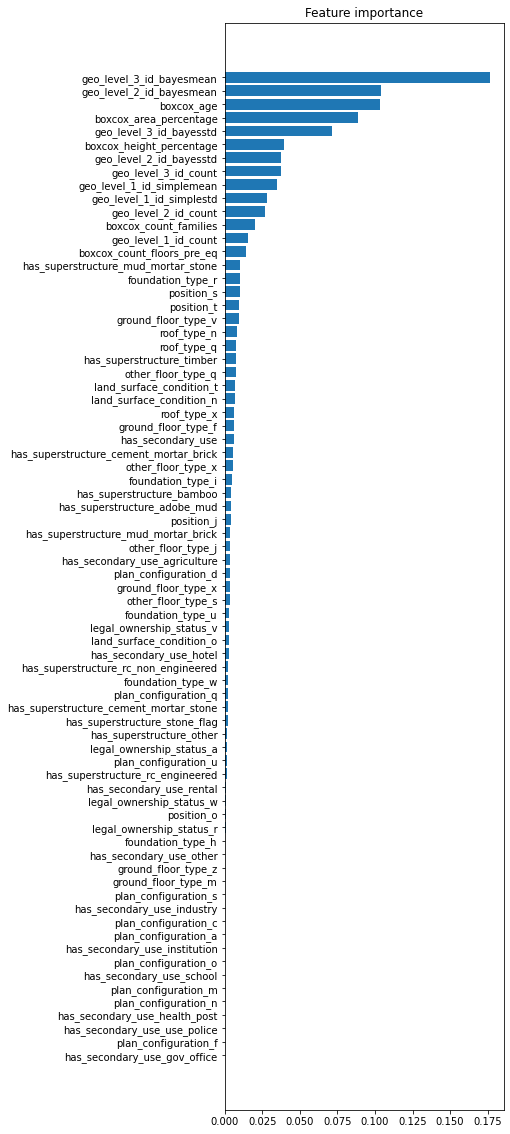

In [34]:
sorted_idx = baseline_model.feature_importances_.argsort()

fig, ax = plt.subplots(figsize = (5, 20))
ax.barh(X_train.columns[sorted_idx], baseline_model.feature_importances_[sorted_idx])
plt.title("Feature importance")

In [36]:
from numpy import sort
from sklearn.feature_selection import RFECV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)

selector = RFECV(estimator = baseline_model, step = 1, cv = 3, scoring = 'f1_micro')
selector = selector.fit(X_train, y_train)

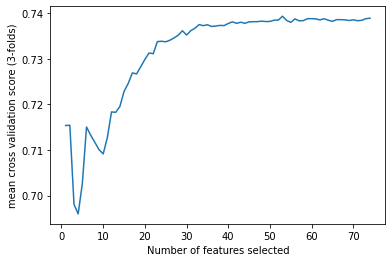

In [31]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("mean cross validation score (3-folds)")
plt.plot(
    range(1, len(selector.cv_results_['mean_test_score']) + 1),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [32]:
selected_fts = []
for idx, col in enumerate(list(X_train.columns)):
    if selector.ranking_[idx] == 1:
        selected_fts.append(col)

len(selected_fts)

53

In [191]:
print(selected_fts)

['boxcox_count_floors_pre_eq', 'boxcox_age', 'boxcox_area_percentage', 'boxcox_height_percentage', 'boxcox_count_families', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'geo_level_1_id_count', 'geo_level_1_id_simplemean', 'geo_level_1_id_simplestd', 'geo_level_2_id_count', 'geo_level_2_id_bayesmean', 'geo_level_2_id_bayesstd', 'geo_level_3_id_count', 'geo_level_3_id_bayesmean', 'geo_level_3_id_bayesstd', 'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w',

In [37]:
# so we don't have to run the RFECV code everytime (takes very long)
selected_fts = ['boxcox_count_floors_pre_eq', 'boxcox_age', 'boxcox_area_percentage', 'boxcox_height_percentage', 'boxcox_count_families', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'geo_level_1_id_count', 'geo_level_1_id_simplemean', 'geo_level_1_id_simplestd', 'geo_level_2_id_count', 'geo_level_2_id_bayesmean', 'geo_level_2_id_bayesstd', 'geo_level_3_id_count', 'geo_level_3_id_bayesmean', 'geo_level_3_id_bayesstd', 'land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w', 'roof_type_n', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f', 'ground_floor_type_v', 'ground_floor_type_x', 'other_floor_type_j', 'other_floor_type_q', 'other_floor_type_s', 'other_floor_type_x', 'position_j', 'position_s', 'position_t', 'plan_configuration_d', 'plan_configuration_q', 'plan_configuration_u', 'legal_ownership_status_a', 'legal_ownership_status_v']

In [38]:
# Restructure the dataframes
new_cols = ['building_id'] + selected_fts + ['damage_grade']

dummy_train = pd.get_dummies(train_lbl) # one-hot-encode categorical features
train_lbl_selected_fts = dummy_train[new_cols]

dummy_test = pd.get_dummies(test)
test_selected_fts = dummy_test[new_cols[:-1]]

In [39]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['damage_grade', 'building_id'], inplace = True)
y_train = train_lbl_selected_fts.iloc[:, -1]

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

baseline_model = RandomForestClassifier(n_jobs=-1,random_state=1)
baseline_model.fit(X_train1, y_train1)
y_pred = baseline_model.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print(score)

0.7398472774715085


In [40]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.57      0.61      7651
           2       0.76      0.81      0.78     44365
           3       0.73      0.66      0.70     26165

    accuracy                           0.74     78181
   macro avg       0.71      0.68      0.70     78181
weighted avg       0.74      0.74      0.74     78181



DO NOT RUN THIS! OLD SELECTION METHOD THAT WAS REPLACED BY RFECV (above code)

In [242]:
### OLD SELECTION METHOD WITHOUT CROSS-VALIDATION

from numpy import sort
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)

fts_importance = baseline_model.feature_importances_
fts_order = []

# Fit model using each importance as a threshold
thresholds = sorted(fts_importance, reverse = True)
for thresh in thresholds:
    # find column name of current threshold feature
    cur_col_idx = np.where(fts_importance == thresh)
    cur_col_name = list(X_train1.columns[cur_col_idx])[0]
    fts_order.append(cur_col_name)
    # select features using threshold
    selection = SelectFromModel(estimator = baseline_model, threshold = thresh, prefit = True)
    select_X_train1 = selection.transform(X_train1)
    # train model
    selection_model = RandomForestClassifier(n_jobs=-1,random_state=1)
    selection_model.fit(select_X_train1, y_train1)
    # eval model
    select_X_val = selection.transform(X_val)
    y_pred = selection_model.predict(select_X_val)
    predictions = [round(value) for value in y_pred]
    score = f1_score(y_val, y_pred, average='micro')
    print('F1 Score: %.2f%%, Thresh=%.3f, n=%d, feature = %s' % (score*100.0, thresh, select_X_train1.shape[1], cur_col_name))

F1 Score: 71.71%, Thresh=0.180, n=1, feature = geo_level_3_id_bayesmean
F1 Score: 71.73%, Thresh=0.104, n=2, feature = geo_level_2_id_bayesmean
F1 Score: 70.00%, Thresh=0.103, n=3, feature = boxcox_age
F1 Score: 70.44%, Thresh=0.089, n=4, feature = boxcox_area_percentage
F1 Score: 70.37%, Thresh=0.071, n=5, feature = geo_level_3_id_bayesstd
F1 Score: 71.56%, Thresh=0.040, n=6, feature = boxcox_height_percentage
F1 Score: 71.40%, Thresh=0.038, n=7, feature = geo_level_2_id_bayesstd
F1 Score: 71.30%, Thresh=0.037, n=8, feature = geo_level_3_id_count
F1 Score: 70.98%, Thresh=0.033, n=9, feature = geo_level_1_id_simplemean
F1 Score: 70.98%, Thresh=0.027, n=10, feature = geo_level_2_id_count
F1 Score: 70.89%, Thresh=0.026, n=11, feature = geo_level_1_id_simplestd
F1 Score: 71.28%, Thresh=0.020, n=12, feature = boxcox_count_families
F1 Score: 71.21%, Thresh=0.016, n=13, feature = geo_level_1_id_count
F1 Score: 71.38%, Thresh=0.015, n=14, feature = boxcox_count_floors_pre_eq
F1 Score: 71.80%,

We can see, that if we keep all features until 'has_secondary_use_other' (n = 58), we will have nearly the same F1 score that we would have if we were to use all 74 features. This leaves us with 58 features, which sounds reasonable when compared to the 260,001 rows we have in our training data.

In [243]:
### OLD SELECTION METHOD WITHOUT CROSS-VALIDATION
# so we do not need to run the above code multiple times (takes very long)
fts_importance = baseline_model.feature_importances_

thresholds = sorted(baseline_model.feature_importances_, reverse = True)
fts_order = []

for thresh in thresholds:
     # find column name of current threshold feature
    cur_col_idx = np.where(fts_importance == thresh)
    cur_col_name = list(X_train1.columns[cur_col_idx])[0]
    fts_order.append(cur_col_name)
    
selected_fts = fts_order[0:58]
selected_fts

['geo_level_3_id_bayesmean',
 'geo_level_2_id_bayesmean',
 'boxcox_age',
 'boxcox_area_percentage',
 'geo_level_3_id_bayesstd',
 'boxcox_height_percentage',
 'geo_level_2_id_bayesstd',
 'geo_level_3_id_count',
 'geo_level_1_id_simplemean',
 'geo_level_2_id_count',
 'geo_level_1_id_simplestd',
 'boxcox_count_families',
 'geo_level_1_id_count',
 'boxcox_count_floors_pre_eq',
 'has_superstructure_mud_mortar_stone',
 'position_s',
 'position_t',
 'foundation_type_r',
 'ground_floor_type_v',
 'roof_type_n',
 'has_superstructure_timber',
 'roof_type_q',
 'other_floor_type_q',
 'land_surface_condition_t',
 'land_surface_condition_n',
 'roof_type_x',
 'ground_floor_type_f',
 'has_superstructure_cement_mortar_brick',
 'has_secondary_use',
 'other_floor_type_x',
 'foundation_type_i',
 'has_superstructure_bamboo',
 'has_superstructure_mud_mortar_brick',
 'position_j',
 'has_superstructure_adobe_mud',
 'other_floor_type_j',
 'other_floor_type_s',
 'has_secondary_use_agriculture',
 'plan_configurat

### Random forest classifier utilizing ordinal scale of target variable

In [38]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [39]:
# taken from https://github.com/alan-flint/Richter-DrivenData/tree/master/src

from sklearn.base import clone

class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [40]:
rf_basic = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, n_jobs=-1)
rf_ordinal = OrdinalClassifier(rf_basic)
rf_ordinal.fit(X_train1, y_train1)

In [41]:
y_pred = rf_ordinal.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7598137654928948


In [42]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63      7536
           1       0.76      0.85      0.80     44502
           2       0.77      0.66      0.71     26143

    accuracy                           0.76     78181
   macro avg       0.75      0.69      0.72     78181
weighted avg       0.76      0.76      0.76     78181



In [45]:
# Predict test data
y_test = rf_ordinal.predict(X_test)

In [46]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [47]:
pred_df.to_csv('Predictions/rf_ordinal.csv',index=False)

This gets us a score on the competition (with selecting only 53 features) of .7489 (top 3%)

#### Hyperparameter tuning

In [48]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [49]:
from sklearn.model_selection import RandomizedSearchCV 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [48]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_basic_hpt = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, verbose = 1, n_jobs=-1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_basic_hpt_random = RandomizedSearchCV(estimator = rf_basic_hpt, param_distributions = random_grid,
                                           n_iter = 50, cv = 3, verbose = 10, random_state = 42, 
                                           n_jobs = -1)# Fit the random search model
rf_basic_hpt_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.1s finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(min_samples_leaf=5,
                                                    n_jobs=-1, verbose=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=10)

In [49]:
rf_basic_hpt_random.cv_results_

{'mean_fit_time': array([357.96681539,  99.11466877, 146.0797654 , 168.47522171,
         55.10068003, 361.41585708, 359.95805041, 370.19202185,
        383.09951218, 233.8210686 , 174.56520096, 211.82299169,
        456.86998725, 218.74714422, 475.03510237, 219.04379034,
        389.53446714, 276.57205073, 332.99485763, 205.63303288,
        201.37531813, 207.43859577, 293.01670194, 174.09508355,
        107.69661919, 359.73019934, 325.67760126, 292.00995024,
        297.20140465, 137.31565166, 142.65225323, 240.27231312,
        100.55049499, 367.23386097, 148.15194281,  89.00404859,
         72.58099453, 314.46856968, 144.06714606,  65.89348952,
        250.16414483, 205.53613249, 277.25466053, 179.44190152,
        103.01357754, 130.49759618, 233.08099008, 261.36668452,
        106.52435994, 146.63023488]),
 'std_fit_time': array([ 3.68432289,  5.78151975,  0.6457293 , 17.41287297,  4.2547607 ,
        26.75915636,  2.35980699,  3.01761274,  0.42197659, 17.63121044,
         9.1207

In [64]:
best_param = rf_basic_hpt_random.best_params_
best_model = rf_basic_hpt_random.best_estimator_

In [60]:
# n_iter = 50 with cv = 3 gave: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
best_model = RandomForestClassifier(n_estimators = 400, 
                                    max_features = 'auto',
                                    max_depth = 20,
                                    min_samples_split = 5,
                                    min_samples_leaf = 4,
                                    bootstrap = True,
                                    verbose = 1,
                                    n_jobs = -1)
best_model.fit(X_train1, y_train1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.5s finished


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=400, n_jobs=-1, verbose=1)

In [61]:
y_pred = best_model.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s


micro f1 cross val: 0.7592637597370205


[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.7s finished


In [62]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62      7582
           1       0.76      0.86      0.80     44420
           2       0.77      0.66      0.71     26179

    accuracy                           0.76     78181
   macro avg       0.75      0.69      0.71     78181
weighted avg       0.76      0.76      0.75     78181



In [63]:
# Predict test data
y_test = best_model.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.7s finished


In [64]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [65]:
pred_df.to_csv('Predictions/rf_basic_hpt.csv',index=False)

In [66]:
rf_ordinal_hpt_random = OrdinalClassifier(best_model)
rf_ordinal_hpt_random.fit(X_train1, y_train1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.2s finished


In [67]:
y_pred = rf_ordinal_hpt_random.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s


micro f1 cross val: 0.759724229672171


[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.6s finished


In [68]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62      7582
           1       0.76      0.85      0.80     44420
           2       0.77      0.66      0.71     26179

    accuracy                           0.76     78181
   macro avg       0.75      0.69      0.71     78181
weighted avg       0.76      0.76      0.76     78181



In [69]:
# Predict test data
y_test = rf_ordinal_hpt_random.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.6s finished


In [70]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [71]:
pred_df.to_csv('Predictions/rf_ordinal_hpt.csv',index=False)

### XGBoost

In [72]:
from xgboost import XGBClassifier

In [73]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [74]:
# create model using train_test_split
xgboost_basic = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False)

xgboost_basic.fit(X_train1, y_train1, eval_metric = 'mlogloss', verbose = False)
y_pred = xgboost_basic.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7610544761514945


In [75]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.59      0.64      7539
           1       0.77      0.84      0.80     44567
           2       0.77      0.67      0.71     26075

    accuracy                           0.76     78181
   macro avg       0.74      0.70      0.72     78181
weighted avg       0.76      0.76      0.76     78181



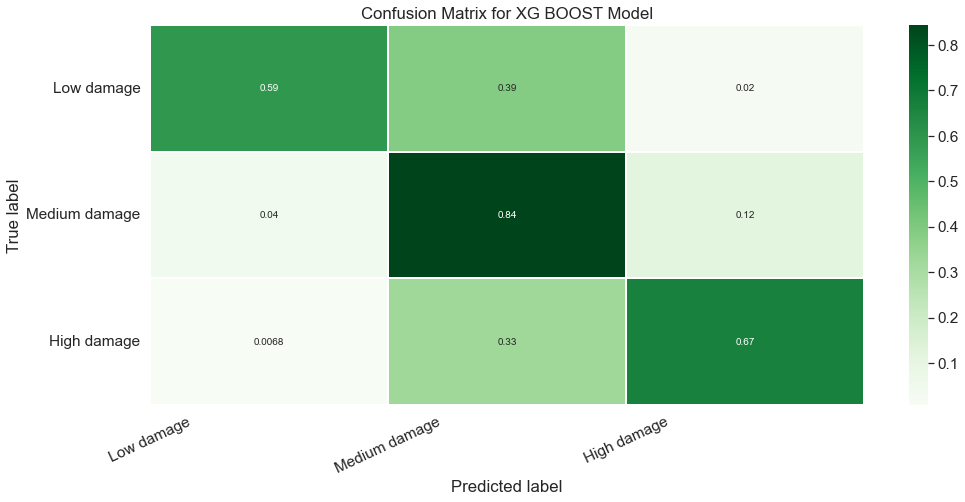

In [76]:
# confusion matrix
matrix = confusion_matrix(y_val, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Low damage', 'Medium damage', 'High damage']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG BOOST Model')
plt.show()

In [77]:
# Predict test data
y_test = xgboost_basic.predict(X_test)

In [78]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [79]:
pred_df.to_csv('Predictions/xgboost_basic.csv',index=False)

### Hypertuned XGBoost

In [80]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [83]:
space = {'eta': hp.uniform('eta', 0.001, 0.2), # 0.001, 0.5
         'gamma': hp.uniform('gamma', 0, 9), # 0, 9
         'n_estimators': hp.uniform('n_estimators', 100, 200), # 100, 200
         'reg_lambda': hp.uniform('reg_lambda', 0, 1), # 0, 1
         #'max_depth': hp.quniform('max_depth', 4, 8, 1), # TUNE WITH CV
         #'seed': 0
         #'min_child_weight': hp.quniform('min_child_weight', 0, 5, 1), # TUNE WITH CV
         #'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
         #'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        }

# fit_params = {'eval_set': evaluation, 'eval_metric': 'mlogloss', 'early_stopping_rounds': 10, 'verbose': False}

def objective(space):
    clf = XGBClassifier(eta = space['eta'],
                        gamma = space['gamma'],
                        n_estimators = int(space['n_estimators']),
                        reg_lambda = space['reg_lambda'],
                        use_label_encoder=False, # labels are already encoded
                        #max_depth = int(space['max_depth']),
                        #min_child_weight=int(space['min_child_weight']),
                        #colsample_bytree=int(space['colsample_bytree']),
                        #reg_alpha = int(space['reg_alpha']),
                       )
                        
    evaluation = [(X_train1, y_train1), (X_val, y_val)]
    
    # f1_micro evaluation score
    clf.fit(X_train1, y_train1,
            eval_set=evaluation,
            eval_metric='mlogloss',
            early_stopping_rounds=10,
            verbose=False
           )
    pred = clf.predict(X_val)
    score = f1_score(y_val, pred, average = 'micro')
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK }

In [84]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25, # 25 gives good results, needs 12.5 min to run; more never bad
                        trials = trials)

SCORE:                                                                                                                 
0.7614765735920492                                                                                                     
SCORE:                                                                                                                 
0.7624870492830739                                                                                                     
SCORE:                                                                                                                 
0.7602870262595771                                                                                                     
SCORE:                                                                                                                 
0.7584195648559113                                                                                                     
SCORE:                                  

In [85]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

# 25 training rounds gave f1 score of 0.77819419 with 
# {'eta': 0.1433612999617697, 'gamma': 0.5688161605576953, 'n_estimators': 153.34948103469924, 'reg_lambda': 0.1510991702875506}

The best hyperparameters are :  

{'eta': 0.1433612999617697, 'gamma': 0.5688161605576953, 'n_estimators': 153.34948103469924, 'reg_lambda': 0.1510991702875506}


In [87]:
# take hypertuned parameters and train model on FULL training set
xgboost_hpt = XGBClassifier(objective='multiclass:softmax', eval_metric='mlogloss',
                            eta = best_hyperparams['eta'],
                            gamma = best_hyperparams['gamma'],
                            n_estimators = int(best_hyperparams['n_estimators']),
                            reg_lambda = best_hyperparams['reg_lambda'],
                            use_label_encoder = False, # labels are already encoded
                            #max_depth = space['max_depth'],
                            #min_child_weight=int(space['min_child_weight']),
                            #colsample_bytree=int(space['colsample_bytree']),
                            #reg_alpha = int(space['reg_alpha']),
                           )
xgboost_hpt.fit(X_train1, y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1433612999617697, eval_metric='mlogloss',
              gamma=0.5688161605576953, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1433613,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=153, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.1510991702875506,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, ...)

In [88]:
xgboost_hpt.fit(X_train1, y_train1)

y_pred = xgboost_hpt.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7630114733758842


In [89]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.58      0.63      7529
           1       0.77      0.85      0.81     44716
           2       0.77      0.67      0.72     25936

    accuracy                           0.76     78181
   macro avg       0.74      0.70      0.72     78181
weighted avg       0.76      0.76      0.76     78181



In [90]:
# Predict test data (of simple model, no validation, no class weights)
y_test = xgboost_hpt.predict(X_test)

In [91]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [92]:
pred_df['damage_grade'].value_counts()

2    54497
3    25347
1     7024
Name: damage_grade, dtype: int64

In [93]:
pred_df.to_csv('Predictions/xgboost_hypertuned.csv',index=False)

### CatBoost

In [94]:
from catboost import CatBoostClassifier

In [100]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [101]:
# create model using train_test_split
catboost_basic = CatBoostClassifier(iterations = 400, learning_rate = 0.1, random_strength = 0.1, depth = 10, 
                                    loss_function = 'MultiClass', eval_metric = 'AUC', 
                                    leaf_estimation_method='Newton',use_best_model=True)
catboost_basic.fit(X_train1, y_train1, eval_set = (X_val, y_val), plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8977337	best: 0.8977337 (0)	total: 104ms	remaining: 41.6s
1:	test: 0.9033880	best: 0.9033880 (1)	total: 211ms	remaining: 42s
2:	test: 0.9057592	best: 0.9057592 (2)	total: 316ms	remaining: 41.8s
3:	test: 0.9097562	best: 0.9097562 (3)	total: 423ms	remaining: 41.8s
4:	test: 0.9114943	best: 0.9114943 (4)	total: 532ms	remaining: 42s
5:	test: 0.9136209	best: 0.9136209 (5)	total: 643ms	remaining: 42.3s
6:	test: 0.9150468	best: 0.9150468 (6)	total: 756ms	remaining: 42.4s
7:	test: 0.9163041	best: 0.9163041 (7)	total: 860ms	remaining: 42.1s
8:	test: 0.9172926	best: 0.9172926 (8)	total: 967ms	remaining: 42s
9:	test: 0.9187845	best: 0.9187845 (9)	total: 1.08s	remaining: 42.2s
10:	test: 0.9198714	best: 0.9198714 (10)	total: 1.19s	remaining: 42.1s
11:	test: 0.9211832	best: 0.9211832 (11)	total: 1.29s	remaining: 41.9s
12:	test: 0.9222335	best: 0.9222335 (12)	total: 1.4s	remaining: 41.7s
13:	test: 0.9231730	best: 0.9231730 (13)	total: 1.51s	remaining: 41.6s
14:	test: 0.9239489	best: 0.92394

116:	test: 0.9360002	best: 0.9360002 (116)	total: 12.6s	remaining: 30.4s
117:	test: 0.9360285	best: 0.9360285 (117)	total: 12.7s	remaining: 30.3s
118:	test: 0.9360429	best: 0.9360429 (118)	total: 12.8s	remaining: 30.2s
119:	test: 0.9360568	best: 0.9360568 (119)	total: 12.9s	remaining: 30.1s
120:	test: 0.9360779	best: 0.9360779 (120)	total: 13s	remaining: 30s
121:	test: 0.9361228	best: 0.9361228 (121)	total: 13.1s	remaining: 29.9s
122:	test: 0.9361257	best: 0.9361257 (122)	total: 13.2s	remaining: 29.8s
123:	test: 0.9361360	best: 0.9361360 (123)	total: 13.3s	remaining: 29.7s
124:	test: 0.9361466	best: 0.9361466 (124)	total: 13.4s	remaining: 29.6s
125:	test: 0.9361543	best: 0.9361543 (125)	total: 13.5s	remaining: 29.5s
126:	test: 0.9361526	best: 0.9361543 (125)	total: 13.7s	remaining: 29.4s
127:	test: 0.9361620	best: 0.9361620 (127)	total: 13.8s	remaining: 29.3s
128:	test: 0.9361677	best: 0.9361677 (128)	total: 13.9s	remaining: 29.2s
129:	test: 0.9361871	best: 0.9361871 (129)	total: 14s	r

229:	test: 0.9369371	best: 0.9369467 (227)	total: 24.8s	remaining: 18.3s
230:	test: 0.9369339	best: 0.9369467 (227)	total: 24.9s	remaining: 18.2s
231:	test: 0.9369341	best: 0.9369467 (227)	total: 25s	remaining: 18.1s
232:	test: 0.9369358	best: 0.9369467 (227)	total: 25.1s	remaining: 18s
233:	test: 0.9369402	best: 0.9369467 (227)	total: 25.2s	remaining: 17.9s
234:	test: 0.9369391	best: 0.9369467 (227)	total: 25.3s	remaining: 17.8s
235:	test: 0.9369399	best: 0.9369467 (227)	total: 25.4s	remaining: 17.7s
236:	test: 0.9369390	best: 0.9369467 (227)	total: 25.5s	remaining: 17.6s
237:	test: 0.9369474	best: 0.9369474 (237)	total: 25.6s	remaining: 17.4s
238:	test: 0.9369571	best: 0.9369571 (238)	total: 25.7s	remaining: 17.3s
239:	test: 0.9369509	best: 0.9369571 (238)	total: 25.9s	remaining: 17.2s
240:	test: 0.9369529	best: 0.9369571 (238)	total: 26s	remaining: 17.1s
241:	test: 0.9369552	best: 0.9369571 (238)	total: 26.1s	remaining: 17s
242:	test: 0.9369414	best: 0.9369571 (238)	total: 26.2s	rem

342:	test: 0.9370298	best: 0.9370969 (305)	total: 37s	remaining: 6.15s
343:	test: 0.9370309	best: 0.9370969 (305)	total: 37.1s	remaining: 6.04s
344:	test: 0.9370275	best: 0.9370969 (305)	total: 37.2s	remaining: 5.93s
345:	test: 0.9370288	best: 0.9370969 (305)	total: 37.3s	remaining: 5.83s
346:	test: 0.9370212	best: 0.9370969 (305)	total: 37.4s	remaining: 5.72s
347:	test: 0.9370227	best: 0.9370969 (305)	total: 37.6s	remaining: 5.61s
348:	test: 0.9370198	best: 0.9370969 (305)	total: 37.7s	remaining: 5.5s
349:	test: 0.9370228	best: 0.9370969 (305)	total: 37.8s	remaining: 5.4s
350:	test: 0.9370221	best: 0.9370969 (305)	total: 37.9s	remaining: 5.29s
351:	test: 0.9370148	best: 0.9370969 (305)	total: 38s	remaining: 5.18s
352:	test: 0.9370211	best: 0.9370969 (305)	total: 38.1s	remaining: 5.07s
353:	test: 0.9370197	best: 0.9370969 (305)	total: 38.2s	remaining: 4.96s
354:	test: 0.9370234	best: 0.9370969 (305)	total: 38.3s	remaining: 4.86s
355:	test: 0.9370203	best: 0.9370969 (305)	total: 38.4s	r

In [102]:
y_pred = catboost_basic.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7615789002443049


In [106]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.58      0.63      7590
           1       0.76      0.85      0.80     44237
           2       0.78      0.66      0.72     26354

    accuracy                           0.76     78181
   macro avg       0.75      0.70      0.72     78181
weighted avg       0.76      0.76      0.76     78181



In [103]:
# Predict test data (of simple model, no validation, no class weights)
y_test = catboost_basic.predict(X_test)

In [104]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [105]:
pred_df.to_csv('Predictions/catboost_selectedfeatures.csv',index=False)

However, CatBoost can also handle categorical variables directly (it will apply one-hot-encoding to them) and in its documentary, the package providers state that encoding variables by yourself actually decreases your score. Therefore, we also try CatBoost without any one-hot-encoding (thus also without feature selection).

In [108]:
# no encoding of left over categorical variables! CatBoost will do this for us!
X_train = train_lbl.copy()
X_train.drop(columns = ['damage_grade', 'building_id'], inplace = True)

X_test = test.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [109]:
cat_fts

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [110]:
# create model using train_test_split
catboost_basic = CatBoostClassifier(iterations = 400, learning_rate = 0.1, random_strength = 0.1, depth = 10, 
                                    loss_function = 'MultiClass', eval_metric = 'AUC', 
                                    leaf_estimation_method='Newton',use_best_model=True)
catboost_basic.fit(X_train1, y_train1, cat_features = cat_fts, eval_set = (X_val, y_val), plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8982000	best: 0.8982000 (0)	total: 426ms	remaining: 2m 49s
1:	test: 0.9041988	best: 0.9041988 (1)	total: 859ms	remaining: 2m 51s
2:	test: 0.9068059	best: 0.9068059 (2)	total: 1.29s	remaining: 2m 50s
3:	test: 0.9103972	best: 0.9103972 (3)	total: 1.75s	remaining: 2m 53s
4:	test: 0.9119698	best: 0.9119698 (4)	total: 2.21s	remaining: 2m 54s
5:	test: 0.9137081	best: 0.9137081 (5)	total: 2.65s	remaining: 2m 54s
6:	test: 0.9151537	best: 0.9151537 (6)	total: 3.1s	remaining: 2m 54s
7:	test: 0.9163967	best: 0.9163967 (7)	total: 3.54s	remaining: 2m 53s
8:	test: 0.9180631	best: 0.9180631 (8)	total: 3.99s	remaining: 2m 53s
9:	test: 0.9195352	best: 0.9195352 (9)	total: 4.43s	remaining: 2m 52s
10:	test: 0.9210440	best: 0.9210440 (10)	total: 4.88s	remaining: 2m 52s
11:	test: 0.9222931	best: 0.9222931 (11)	total: 5.32s	remaining: 2m 52s
12:	test: 0.9230038	best: 0.9230038 (12)	total: 5.78s	remaining: 2m 52s
13:	test: 0.9237916	best: 0.9237916 (13)	total: 6.23s	remaining: 2m 51s
14:	test: 0.9

114:	test: 0.9363754	best: 0.9363754 (114)	total: 55.2s	remaining: 2m 16s
115:	test: 0.9364049	best: 0.9364049 (115)	total: 55.6s	remaining: 2m 16s
116:	test: 0.9364297	best: 0.9364297 (116)	total: 56.1s	remaining: 2m 15s
117:	test: 0.9364335	best: 0.9364335 (117)	total: 56.7s	remaining: 2m 15s
118:	test: 0.9364561	best: 0.9364561 (118)	total: 57.2s	remaining: 2m 15s
119:	test: 0.9364611	best: 0.9364611 (119)	total: 57.7s	remaining: 2m 14s
120:	test: 0.9364785	best: 0.9364785 (120)	total: 58.2s	remaining: 2m 14s
121:	test: 0.9364971	best: 0.9364971 (121)	total: 58.7s	remaining: 2m 13s
122:	test: 0.9365129	best: 0.9365129 (122)	total: 59.2s	remaining: 2m 13s
123:	test: 0.9365311	best: 0.9365311 (123)	total: 59.7s	remaining: 2m 12s
124:	test: 0.9365476	best: 0.9365476 (124)	total: 1m	remaining: 2m 12s
125:	test: 0.9365516	best: 0.9365516 (125)	total: 1m	remaining: 2m 12s
126:	test: 0.9365751	best: 0.9365751 (126)	total: 1m 1s	remaining: 2m 11s
127:	test: 0.9365708	best: 0.9365751 (126)	t

225:	test: 0.9371505	best: 0.9371522 (224)	total: 1m 52s	remaining: 1m 26s
226:	test: 0.9371559	best: 0.9371559 (226)	total: 1m 53s	remaining: 1m 26s
227:	test: 0.9371862	best: 0.9371862 (227)	total: 1m 53s	remaining: 1m 25s
228:	test: 0.9371922	best: 0.9371922 (228)	total: 1m 54s	remaining: 1m 25s
229:	test: 0.9371951	best: 0.9371951 (229)	total: 1m 54s	remaining: 1m 24s
230:	test: 0.9372011	best: 0.9372011 (230)	total: 1m 55s	remaining: 1m 24s
231:	test: 0.9372053	best: 0.9372053 (231)	total: 1m 55s	remaining: 1m 23s
232:	test: 0.9372167	best: 0.9372167 (232)	total: 1m 56s	remaining: 1m 23s
233:	test: 0.9372103	best: 0.9372167 (232)	total: 1m 56s	remaining: 1m 22s
234:	test: 0.9372172	best: 0.9372172 (234)	total: 1m 57s	remaining: 1m 22s
235:	test: 0.9372180	best: 0.9372180 (235)	total: 1m 57s	remaining: 1m 21s
236:	test: 0.9372179	best: 0.9372180 (235)	total: 1m 58s	remaining: 1m 21s
237:	test: 0.9372280	best: 0.9372280 (237)	total: 1m 59s	remaining: 1m 21s
238:	test: 0.9372342	best

337:	test: 0.9373330	best: 0.9373388 (289)	total: 2m 51s	remaining: 31.4s
338:	test: 0.9373330	best: 0.9373388 (289)	total: 2m 52s	remaining: 31s
339:	test: 0.9373368	best: 0.9373388 (289)	total: 2m 52s	remaining: 30.4s
340:	test: 0.9373355	best: 0.9373388 (289)	total: 2m 53s	remaining: 29.9s
341:	test: 0.9373305	best: 0.9373388 (289)	total: 2m 53s	remaining: 29.5s
342:	test: 0.9373270	best: 0.9373388 (289)	total: 2m 54s	remaining: 28.9s
343:	test: 0.9373295	best: 0.9373388 (289)	total: 2m 54s	remaining: 28.4s
344:	test: 0.9373300	best: 0.9373388 (289)	total: 2m 55s	remaining: 27.9s
345:	test: 0.9373267	best: 0.9373388 (289)	total: 2m 55s	remaining: 27.4s
346:	test: 0.9373232	best: 0.9373388 (289)	total: 2m 56s	remaining: 26.9s
347:	test: 0.9373269	best: 0.9373388 (289)	total: 2m 56s	remaining: 26.4s
348:	test: 0.9373219	best: 0.9373388 (289)	total: 2m 57s	remaining: 25.9s
349:	test: 0.9373299	best: 0.9373388 (289)	total: 2m 57s	remaining: 25.4s
350:	test: 0.9373299	best: 0.9373388 (28

In [111]:
y_pred = catboost_basic.predict(X_val)
score = f1_score(y_val, y_pred, average='micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7632800808380553


In [112]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.59      0.64      7475
           1       0.77      0.85      0.81     44522
           2       0.77      0.67      0.72     26184

    accuracy                           0.76     78181
   macro avg       0.74      0.70      0.72     78181
weighted avg       0.76      0.76      0.76     78181



In [113]:
# Predict test data (of simple model, no validation, no class weights)
y_test = catboost_basic.predict(X_test)

In [114]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [115]:
pred_df.to_csv('Predictions/catboost_allfeatures.csv',index=False)

### Light GBM classifier utilizing Gradient Boosting Decision Trees

In [116]:
import lightgbm as lgb

In [117]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [118]:
lgb_basic = lgb.LGBMClassifier(learning_rate=0.1,max_depth=10,random_state=42,boosting_type="gbdt",n_estimators=400,num_leaves=22,num_class=3)
lgb_basic.fit(X_train1,y_train1,eval_set=[(X_val,y_val)],verbose=20,eval_metric='logloss')
print('Training accuracy {:.4f}'.format(lgb_basic.score(X_train1, y_train1)))
print('Testing accuracy {:.4f}'.format(lgb_basic.score(X_val, y_val)))

[20]	valid_0's multi_logloss: 0.559439
[40]	valid_0's multi_logloss: 0.533676
[60]	valid_0's multi_logloss: 0.526843
[80]	valid_0's multi_logloss: 0.524053
[100]	valid_0's multi_logloss: 0.522696
[120]	valid_0's multi_logloss: 0.521795
[140]	valid_0's multi_logloss: 0.521076
[160]	valid_0's multi_logloss: 0.520474
[180]	valid_0's multi_logloss: 0.520004
[200]	valid_0's multi_logloss: 0.519705
[220]	valid_0's multi_logloss: 0.519289
[240]	valid_0's multi_logloss: 0.519029
[260]	valid_0's multi_logloss: 0.518893
[280]	valid_0's multi_logloss: 0.518713
[300]	valid_0's multi_logloss: 0.518533
[320]	valid_0's multi_logloss: 0.518459
[340]	valid_0's multi_logloss: 0.518353
[360]	valid_0's multi_logloss: 0.518276
[380]	valid_0's multi_logloss: 0.518275
[400]	valid_0's multi_logloss: 0.518252
Training accuracy 0.7829
Testing accuracy 0.7615


In [119]:
lgb_basic.fit(X_train1, y_train1)

LGBMClassifier(max_depth=10, n_estimators=400, num_class=3, num_leaves=22,
               random_state=42)

***5-fold Cross Validation*** of Light GBM Model

In [121]:
from sklearn.model_selection import cross_validate
print(cross_validate(lgb_basic, X_train, y_train, cv = 5, scoring = 'f1_micro'))

{'fit_time': array([2.89924669, 2.92118883, 2.8802979 , 2.94911385, 2.9221859 ]), 'score_time': array([0.31017041, 0.31116772, 0.29919982, 0.30418754, 0.30019712]), 'test_score': array([0.76120949, 0.76076362, 0.76329624, 0.76185725, 0.76423638])}


In [122]:
y_pred = lgb_basic.predict(X_val)
score = f1_score(y_val, y_pred, average = 'micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7614509919289854


In [123]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64      7490
           1       0.77      0.85      0.80     44553
           2       0.77      0.66      0.71     26138

    accuracy                           0.76     78181
   macro avg       0.74      0.70      0.72     78181
weighted avg       0.76      0.76      0.76     78181



In [124]:
# Predict test data
y_test = lgb_basic.predict(X_test)

In [125]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,3
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [126]:
pred_df.to_csv('Predictions/lgb_basic.csv',index=False)

### kNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier as kNC

In [128]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [129]:
print(cross_validate(kNC(n_neighbors = 10), X_train, y_train, cv = 5, scoring = 'f1_micro'))

{'fit_time': array([0.10474992, 0.10073185, 0.10075665, 0.10871029, 0.1007309 ]), 'score_time': array([131.18413043, 140.82230353, 147.99464917, 137.45249891,
       146.16790867]), 'test_score': array([0.73404194, 0.72814658, 0.73555257, 0.73325019, 0.73265541])}


In [130]:
knn_basic = kNC(n_neighbors = 25).fit(X_train1, y_train1)

In [131]:
y_pred = knn_basic.predict(X_val)
score = f1_score(y_val, y_pred, average = 'micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7241145546872002


In [132]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50      7602
           1       0.73      0.84      0.78     44377
           2       0.73      0.63      0.67     26202

    accuracy                           0.72     78181
   macro avg       0.71      0.62      0.65     78181
weighted avg       0.72      0.72      0.72     78181



In [133]:
# Predict test data
y_test = knn_basic.predict(X_test)

In [134]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [135]:
pred_df.to_csv('Predictions/knn_basic.csv',index=False)

### Neural Networks

In [136]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.layers import Input, InputLayer

In [137]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [139]:
from sklearn.preprocessing import LabelEncoder
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)

# same for train_test_split
encoder.fit(y_train1)
encoded_y_train1 = encoder.transform(y_train1)
dummy_y_train1 = np_utils.to_categorical(encoded_y_train1)

encoder.fit(y_val)
encoded_y_val = encoder.transform(y_val)
dummy_y_val = np_utils.to_categorical(encoded_y_val)

In [141]:
print(dummy_y_train)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [142]:
def neural_network(inp_dim):
    model = Sequential()
    model.add(InputLayer(input_shape = inp_dim))
    model.add(Dense(50, input_dim=inp_dim, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

In [143]:
nn_model = neural_network(X_train.shape[1])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2700      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 2,853
Trainable params: 2,853
Non-trainable params: 0
_________________________________________________________________


In [145]:
nn_model.fit(X_train1, dummy_y_train1, epochs = 200, batch_size = 50, verbose=1)

Epoch 1/200
3649/3649 [==============================] - 2s 486us/step - loss: 0.6235 - categorical_accuracy: 0.7238
Epoch 2/200
3649/3649 [==============================] - 2s 486us/step - loss: 0.6263 - categorical_accuracy: 0.7218
Epoch 3/200
3649/3649 [==============================] - 2s 485us/step - loss: 0.6264 - categorical_accuracy: 0.7217
Epoch 4/200
3649/3649 [==============================] - 2s 492us/step - loss: 0.6246 - categorical_accuracy: 0.7229
Epoch 5/200
3649/3649 [==============================] - 2s 485us/step - loss: 0.6263 - categorical_accuracy: 0.7224
Epoch 6/200
3649/3649 [==============================] - 2s 480us/step - loss: 0.6238 - categorical_accuracy: 0.7240
Epoch 7/200
3649/3649 [==============================] - 2s 478us/step - loss: 0.6231 - categorical_accuracy: 0.7238
Epoch 8/200
3649/3649 [==============================] - 2s 481us/step - loss: 0.6257 - categorical_accuracy: 0.7240
Epoch 9/200
3649/3649 [==============================] - 2s 479u

3649/3649 [==============================] - 2s 485us/step - loss: 0.6068 - categorical_accuracy: 0.7323
Epoch 140/200
3649/3649 [==============================] - 2s 485us/step - loss: 0.6079 - categorical_accuracy: 0.7316
Epoch 141/200
3649/3649 [==============================] - 2s 484us/step - loss: 0.6086 - categorical_accuracy: 0.7315
Epoch 142/200
3649/3649 [==============================] - 2s 489us/step - loss: 0.6089 - categorical_accuracy: 0.7309
Epoch 143/200
3649/3649 [==============================] - 2s 486us/step - loss: 0.6085 - categorical_accuracy: 0.7314
Epoch 144/200
3649/3649 [==============================] - 2s 486us/step - loss: 0.6063 - categorical_accuracy: 0.7323
Epoch 145/200
3649/3649 [==============================] - 2s 483us/step - loss: 0.6080 - categorical_accuracy: 0.7332
Epoch 146/200
3649/3649 [==============================] - 2s 484us/step - loss: 0.6095 - categorical_accuracy: 0.7316
Epoch 147/200
3649/3649 [==============================] - 2s 

In [148]:
y_pred = nn_model.predict(X_val)
y_pred = y_pred.argmax(axis=-1)
score = f1_score(y_val, y_pred, average = 'micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.7234750131106024


In [149]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      7494
           1       0.71      0.88      0.78     44513
           2       0.85      0.50      0.63     26174

    accuracy                           0.72     78181
   macro avg       0.71      0.66      0.67     78181
weighted avg       0.74      0.72      0.71     78181



In [150]:
y_pred = nn_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

In [151]:
pred_df = pd.DataFrame(test['building_id'])
pred_df.loc[:,'damage_grade'] = y_test + 1
pred_df

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [152]:
pred_df.to_csv('Predictions/nn_basic.csv',index=False)

### Logistic regression

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
X_train = train_lbl_selected_fts.copy()
X_train.drop(columns = ['building_id', 'damage_grade'], inplace = True)

X_test = test_selected_fts.copy()
X_test.drop(columns = ['building_id'], inplace = True)

y_train = train_lbl_selected_fts.iloc[:, -1] - 1 # substract 1 to normalize labels to range [0, 2]
y_train = list(y_train)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [155]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'saga', verbose = True, n_jobs = -1, penalty = 'l2')

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

This class implements regularized logistic regression using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers. Note that regularization is applied by default.

saga and sag solvers have fast covergence when used on standarised data, large data sets use saga or sag small data sets use liblinear.

In [156]:
lr.fit(X_train1, y_train1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


max_iter reached after 17 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   17.1s finished


LogisticRegression(multi_class='multinomial', n_jobs=-1, solver='saga',
                   verbose=True)

In [157]:
y_pred = lr.predict(X_val)
score = f1_score(y_val, y_pred, average = 'micro')
print('micro f1 cross val:', score)

micro f1 cross val: 0.5661349944359882


In [158]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.05      0.09      7581
           1       0.57      0.99      0.72     44220
           2       0.00      0.00      0.00     26380

    accuracy                           0.57     78181
   macro avg       0.36      0.35      0.27     78181
weighted avg       0.37      0.57      0.42     78181



The logistic regression model f1 score was very low with 0.57.

Other models were performimng considerably good. Consequently, we decided to move with other models.